# nsteps TD Learning

Let's see the differences between TD(1) and TD(3) implementing these two types of algorithm using the SARSA approach.

In this kind of environment, the agent can move **up,down,left,right** at every timestep the reward is 0, while for the terminal state the reward is 1.

In [190]:
%run "environment.py"
#goal is -1, empty block is 1, wall is 0, mortal block is 2
#rewards: normal:-0.1, goal:100, mortal block:-100
#maxtimesteps:100

structure=[
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1., -1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.]
]
#maze, step reward, final reward, timesteps, mortal block
env=maze(structure, 0, 100, 1000, -100)
#env.showEnv()

<img src="images/envpicture.png">

## SARSA(1)

Now, let's define our agents. The SARSA(1) and the SARSA(3) one. 
First of all, we need the QTables, every agent will have its own QTable.

Both behave using a e-greedy policy, so we define a *policy* function that is going to be used by both agents to pick up an action based on their QTable.

Remember that in SARSA, we evaluate *q(s,a)* using the *q(s',a')* selected at the next timestep. So, after selected an action and execute it and obtained the next state, we have to select an action also for the new state. Finally, we are going to use this next action at the next timestep. In short, at everytimestep we are going to execute the action selected at the timestep before and select the action for the next timestep.

In [186]:
import random
#hyperparameters
epsilon=0.1
alpha=0.5
discount=0.99
episodes=50

#QTABLES
Q1Table=np.zeros([env.getNStates(), env.getNActions()])
Q3Table=np.zeros([env.getNStates(), env.getNActions()])

#DEFINE POLICY
def policy(state):
    if random.random()<epsilon:
        #pick randomly a integer number between 0 and 3 included
        return random.randint(0,3)
    else:
        #return the action that has the higher q(s,a)
        bestActions=np.argwhere(state == np.amax(state))
        action=np.random.choice(np.reshape(bestActions, -1))        
        return action
    
#DEFINE SARSA AGENT
def SARSA1():
    #list for store info to plot later
    rewardEachEpisode=[]
    stepsEachEpisode=[]
    
    for episode in range(episodes):
        #store value to add to the list
        steps=0
        rewards=0

        #take the first state
        s=env.reset()

        action=policy(Q1Table[s])

        d=False
        while not(d):
            #execute the action
            s1, r, d=env.step(action)

            #next action selection
            nextAction=policy(Q1Table[s1])

            #update Value function
            Q1Table[s][action]=Q1Table[s][action] + alpha * (r + discount*Q1Table[s1][nextAction] - Q1Table[s][action])

            #use the next action at the next timestep
            action=nextAction
            s=s1  
            steps +=1
            rewards+=r
            
        #USED TO DISPLAY THE PATH CREATED IN THE FIRST 2 EPISODES
        if episode<2:
            print("Episode SARSA1 episode", episode)
            path=[]
            for idx, row in enumerate(Q1Table):
                if idx==25:
                    bestAction="G"
                else:
                    bestActions=np.reshape(np.argwhere(row==np.amax(row)), -1)
                    if len(bestActions)>1:
                        bestAction="."
                    else:
                        if bestActions[0]==0:
                            bestAction="↑"
                        elif bestActions[0]==1:
                            bestAction="↓"
                        elif bestActions[0]==2:
                            bestAction="←"
                        else:
                            bestAction="→"
                path.append(bestAction)

            SARSA1Map=np.reshape(path, [7,7])
            plt.figure()
            tb=plt.table(cellText=SARSA1Map,  loc=(0,0), cellLoc='center')
            tc = tb.properties()['child_artists']
            for cell in tc: 
                cell.set_height(1/7)
                cell.set_width(1/7)
            plt.show()
        
        stepsEachEpisode.append(steps)
        rewardEachEpisode.append(rewards)
        
    return rewardEachEpisode, stepsEachEpisode

## SARSA(3)

Now let's define the SARSA(3) agent. 

This agent has to store the rewards of each timestep. Moreover, keep track of the q(s,a) encountered and that are still wait to be update. Infact, every q(s,a) is update 3 timesteps later then when encountered.

In [187]:
import matplotlib.pyplot as plt
def SARSA3():    
    #list for store info to plot later
    rewardEachEpisode=[]
    stepsEachEpisode=[]
    nsteps=3
    
    for episode in range(episodes):
        storeRewards=[]
        storeValueFunctions=[]
        
        steps=0
        rewards=0
        
        s=env.reset()
        
        action=policy(Q3Table[s])
        
        d=False
        while not(d):
            s1, r, d=env.step(action)
            #store q(s,a) to be update
            storeValueFunctions.append([s,action])
            #store the rewards
            storeRewards.append(r)
            
            nextAction=policy(Q3Table[s1])
            #Starting from the third timestep after q(s,a) of the first timestep
            if steps>=nsteps:
                #G=r + yr1 + y^2r2 + y^3q(s^3,a)
                G=0
                for i in range(nsteps):
                    #use the q(s^3,a) for the last term of G
                    if i==(nsteps-1):
                        s3=storeValueFunctions[nsteps][0]
                        a3=storeValueFunctions[nsteps][1]
                        G+=(discount**i)*storeRewards[i] + (discount**(i+1)) * Q3Table[s3][a3]
                    else:
                        G+= (discount**i) * storeRewards[i]
                #retrieve the first q(s,a) stored in the list
                state=storeValueFunctions[0][0]
                a=storeValueFunctions[0][1]
                Q3Table[state][a]=Q3Table[state][a] + alpha * (G - Q3Table[state][a])            
                
                #remove the first reward and first q(s,a) stored. We don't need them anymore once 
                #the QTable has been updated
                del storeRewards[0]
                del storeValueFunctions[0]
                
            #if the game is finished, update all the q(s,a) that still need to be updated
            if d:
                leftValues=len(storeValueFunctions)
                #we don't have a q(s^3,a) to use because game is finished. So, just use rewards
                for element in range(leftValues):
                    G=0
                    for i,rew in enumerate(storeRewards):
                        G+=(discount**i) * rew
                    state=storeValueFunctions[0][0]
                    a=storeValueFunctions[0][1]
                    
                    Q3Table[state][a]=Q3Table[state][a] + alpha * (G - Q3Table[state][a])
                    
                    del storeRewards[0]
                    del storeValueFunctions[0]                   
                
            
            action=nextAction
            s=s1
            steps+=1
            rewards+=r
            
        #USED TO DISPLAY THE PATH CREATED IN THE FIRST 2 EPISODES
        if episode<2:
            print("Episode SARSA3 episode", episode)
            path=[]
            for idx, row in enumerate(Q3Table):
                if idx==25:
                    bestAction="G"
                else:
                    bestActions=np.reshape(np.argwhere(row==np.amax(row)), -1)
                    if len(bestActions)>1:
                        bestAction="."
                    else:
                        if bestActions[0]==0:
                            bestAction="↑"
                        elif bestActions[0]==1:
                            bestAction="↓"
                        elif bestActions[0]==2:
                            bestAction="←"
                        else:
                            bestAction="→"
                path.append(bestAction)
            #stateValue=np.sum(Q3Table, axis=1)
            SARSA3Map=np.reshape(path, [7,7])
            plt.figure()
            tb=plt.table(cellText=SARSA3Map,  loc=(0,0), cellLoc='center')
            tc = tb.properties()['child_artists']
            for cell in tc: 
                cell.set_height(1/7)
                cell.set_width(1/7)
            plt.show()
        
        rewardEachEpisode.append(rewards)
        stepsEachEpisode.append(steps)

    return rewardEachEpisode, stepsEachEpisode

## SARSA(1) VS SARSA(3)

Episode SARSA1 episode 0


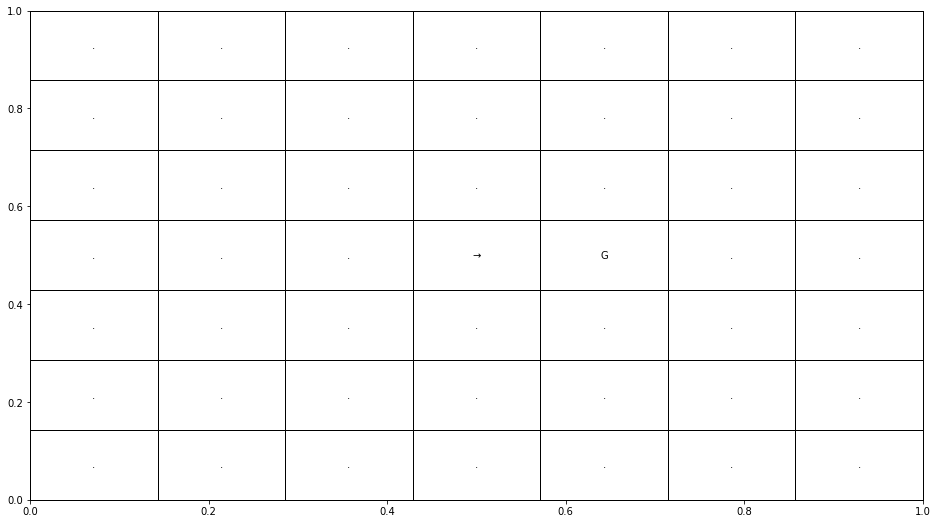

Episode SARSA1 episode 1


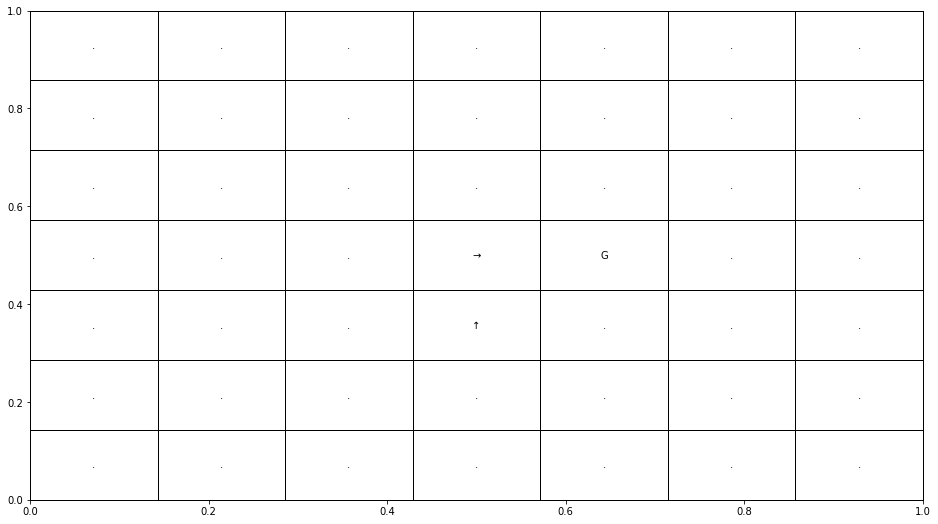

Episode SARSA3 episode 0


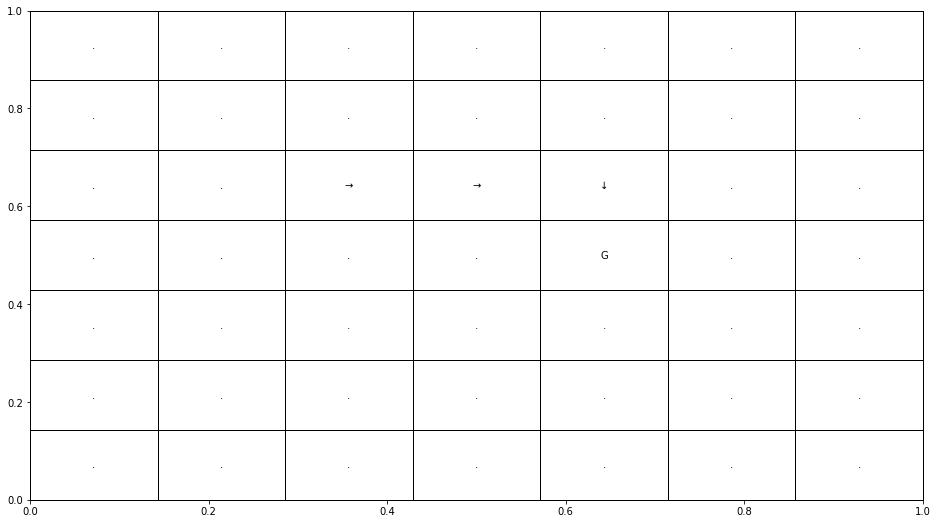

Episode SARSA3 episode 1


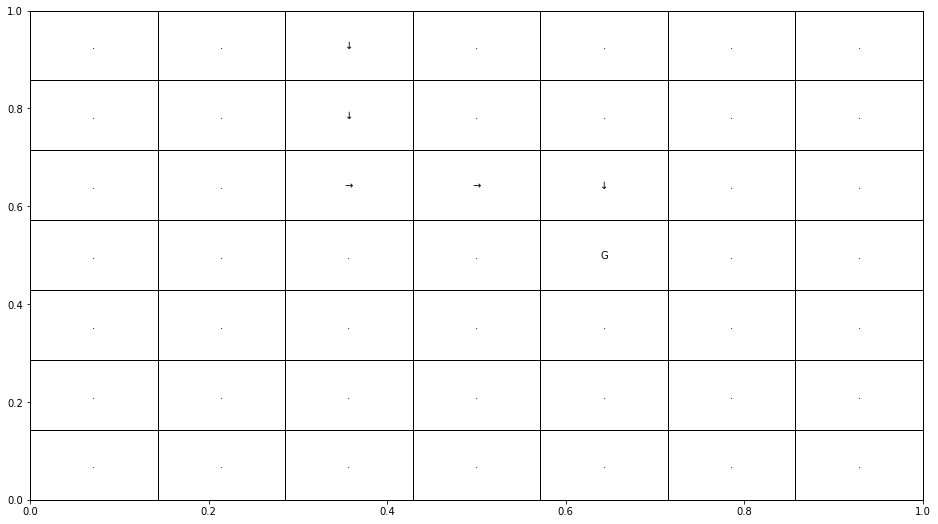

In [188]:
rewList1, stepsList1=SARSA1()
rewList3, stepsList3=SARSA3()

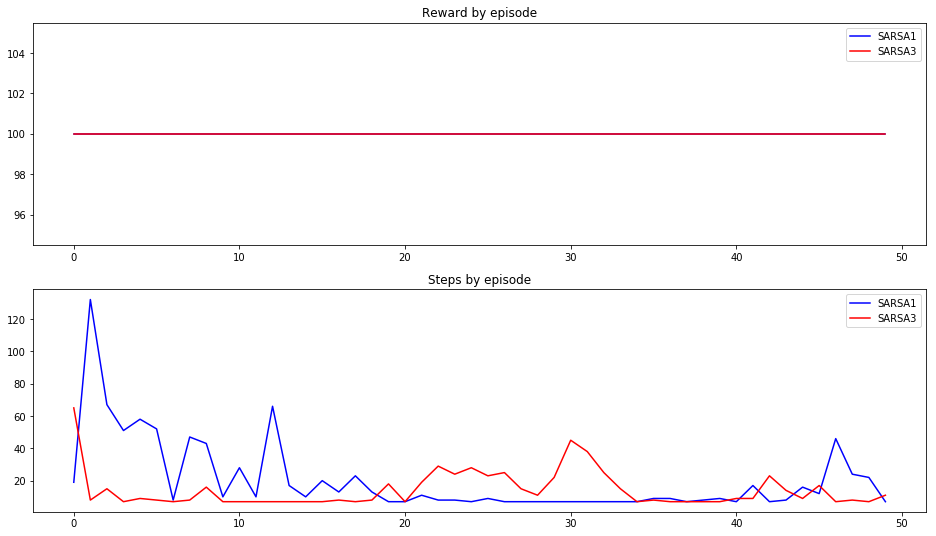

In [189]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [16,9]
fig = plt.figure()
x=[i for i in range(episodes)]

plt1 = fig.add_subplot(2,1,1)
plt1.plot(x, rewList1,  "b-", label="SARSA1")
plt1.plot(x, rewList3, "r-", label="SARSA3")
plt1.set_title("Reward by episode")
plt1.legend(loc=0)

plt2=fig.add_subplot(2,1,2)
plt2.plot(x, stepsList1, "b-", label="SARSA1")
plt2.plot(x, stepsList3, "r-",label="SARSA3")
plt2.set_title("Steps by episode")
plt2.legend(loc=0)

plt.show()